In [ ]:
import torch
from abslrp_gae.abslrp.rules.models import VGGAbsLRPRule, ResNetAbsLRPRule, VisionTransformerAbsLRPRule
from abslrp_gae.abslrp.relevancy_methods import AbsLRPRelevancyMethod
from abslrp_gae.utils import preprocess_image, visualize_batch
import timm
from timm.models.vision_transformer import VisionTransformer
from PIL import Image

# load the model
device = "cuda"
model = timm.create_model("vit_base_patch16_224", pretrained=True)
# model = timm.create_model("vgg16", pretrained=True)
# model = timm.create_model("resnet50", pretrained=True)
model.eval()
model.to(device)

# apply the absLRP rule to the model
VisionTransformerAbsLRPRule().apply(model)
# VGGAbsLRPRule().apply(model)
# ResNetAbsLRPRule().apply(model)

# calculate relevancy
relevancy_method = AbsLRPRelevancyMethod(model, device)
is_vit = isinstance(model, VisionTransformer)
x = torch.stack(
    [
        preprocess_image(Image.open("images/dog_cat.jpeg").convert("RGB"), is_vit),
        preprocess_image(Image.open("images/hedgehog.jpg").convert("RGB"), is_vit),
    ],
    0,
)
relevance = relevancy_method.relevancy(x)

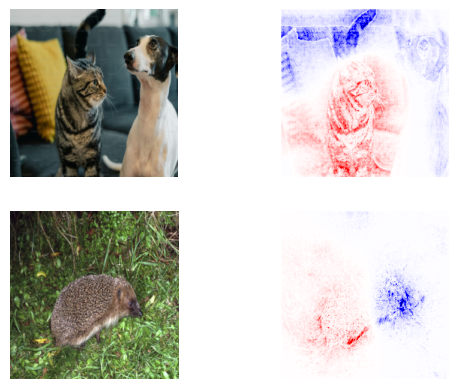

In [16]:
# visualize relevance maps
visualize_batch(x, relevance, is_vit)